In [1]:
# this workbook is for testing the neural network on a year's data and predicting data for a week

In [2]:
# Libraries

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing

mpl.rcParams['figure.figsize'] = (20, 10)
mpl.rcParams['axes.grid'] = False

In [3]:
# Reading csv file to dataframe
df = pd.read_csv('data/combined_data.csv')
df = df[0::22] # only take every 22th row
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/combined_data.csv'

In [ ]:
# converting date time to pandas datetime
date_time=pd.to_datetime(df[['year','month','day','hour']])

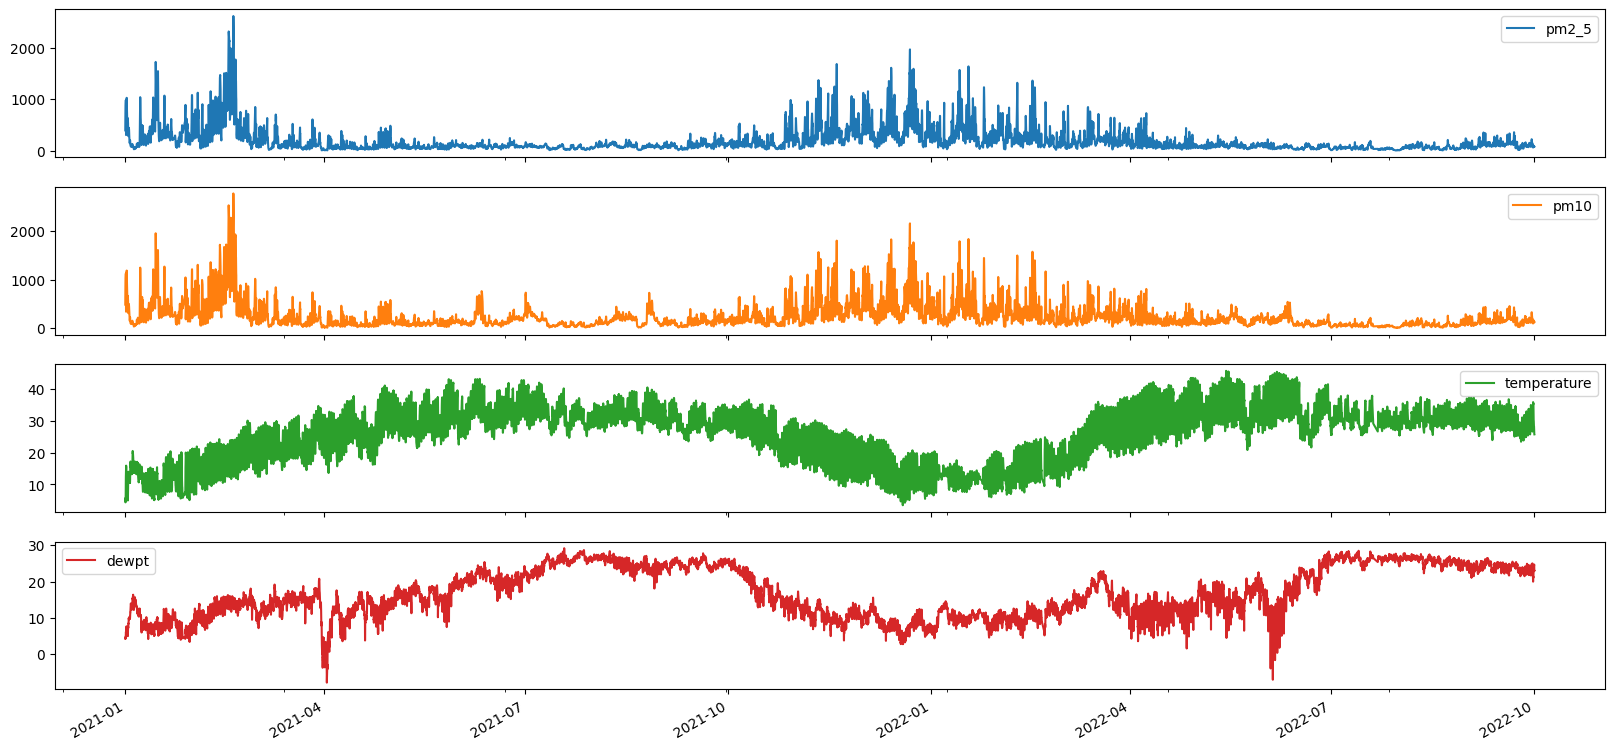

In [ ]:
plot_cols = ['pm2_5','pm10','temperature','dewpt']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

([<matplotlib.lines.Line2D at 0x2c5c26340>],
 <matplotlib.legend.Legend at 0x2e3a45910>)

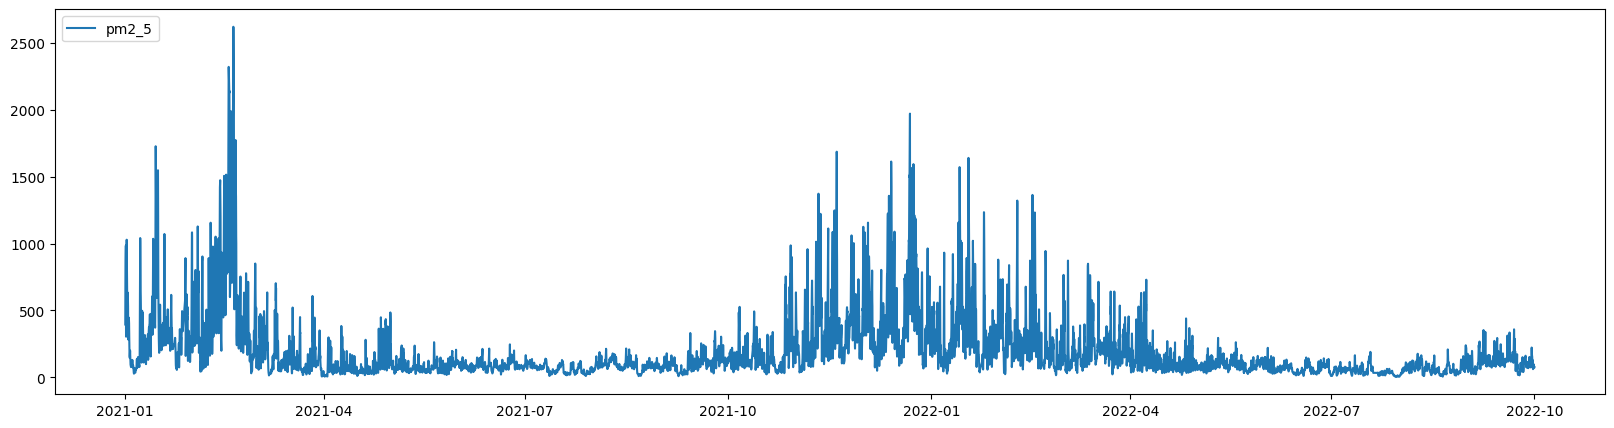

In [ ]:
# plotting pm2_5
pm25 = df['pm2_5']
data = date_time
# figure size
plt.figure(figsize=(20, 5))
plt.plot(data, pm25, label = "pm2_5"), plt.legend(loc='upper left')

([<matplotlib.lines.Line2D at 0x2d0a0ad30>],
 <matplotlib.legend.Legend at 0x2d0a0ad60>)

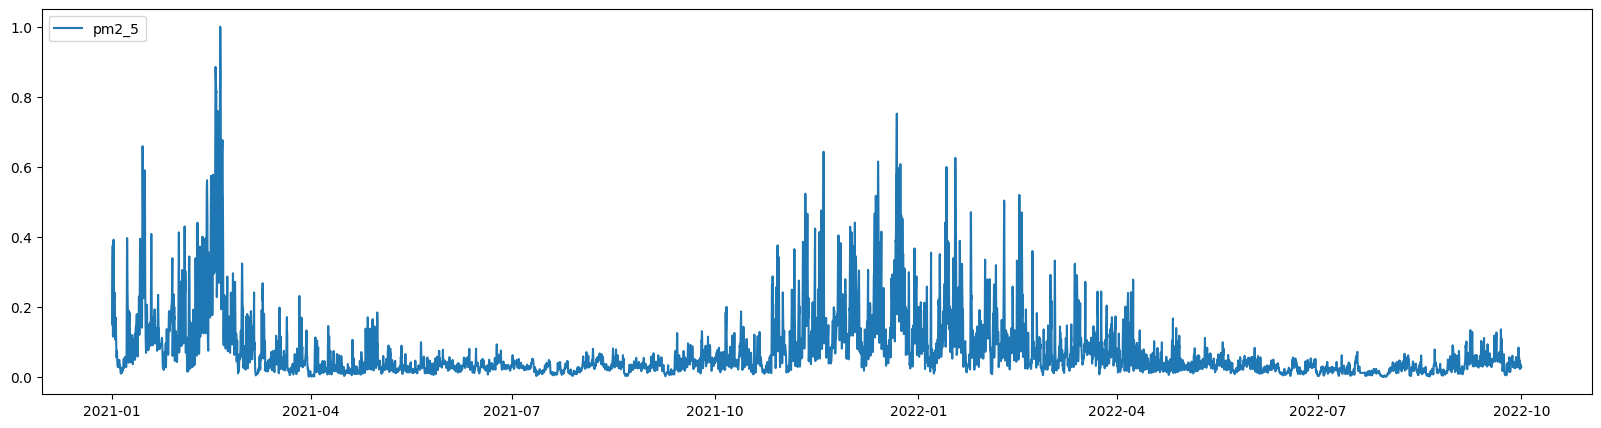

In [ ]:
# using lstm to predict pm2_5
# normalizing data
pm25 = df['pm2_5']
pm25 = pm25.values.reshape(-1, 1)
pm25 = preprocessing.MinMaxScaler().fit_transform(pm25)
pm25 = pm25.reshape(-1)
pm25

# plotting normalized pm2_5
data = date_time
# figure size
plt.figure(figsize=(20, 5))
plt.plot(data, pm25, label = "pm2_5"), plt.legend(loc='upper left')

In [ ]:
# using all pm2_5 data to predict next 7 days
# splitting data into train and test
train_data = pm25[:int(len(pm25)*0.8)]
test_data = pm25[int(len(pm25)*0.8):]

# function to create dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# reshape to [samples, time_steps, n_features]
TIME_STEPS = 7
X_train, y_train = create_dataset(train_data, train_data, TIME_STEPS)
X_test, y_test = create_dataset(test_data, test_data, TIME_STEPS)

# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, shuffle=False)

2022-11-01 00:22:44.720272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-01 00:22:44.895366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  5/684 [..............................] - ETA: 10s - loss: 0.0135  

2022-11-01 00:22:45.048312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


684/684 [==============================] - ETA: 0s - loss: 0.0023

2022-11-01 00:22:53.883418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-01 00:22:53.948798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


684/684 [==============================] - 10s 14ms/step - loss: 0.0023 - val_loss: 4.1019e-04


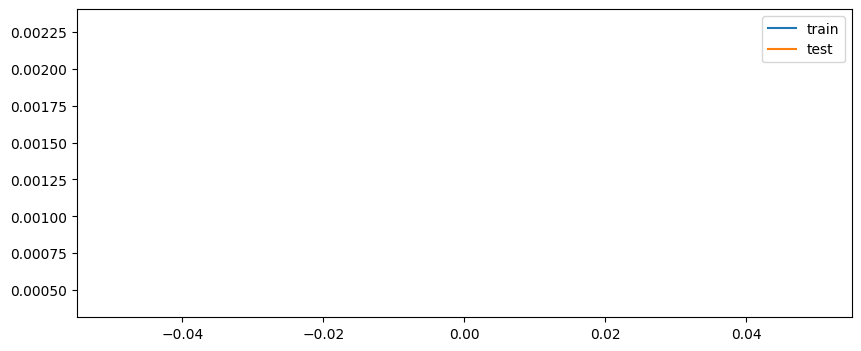

In [ ]:
# plot loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

 1/95 [..............................] - ETA: 48s

2022-11-01 00:22:55.077449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-01 00:22:55.184927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 1s 6ms/step


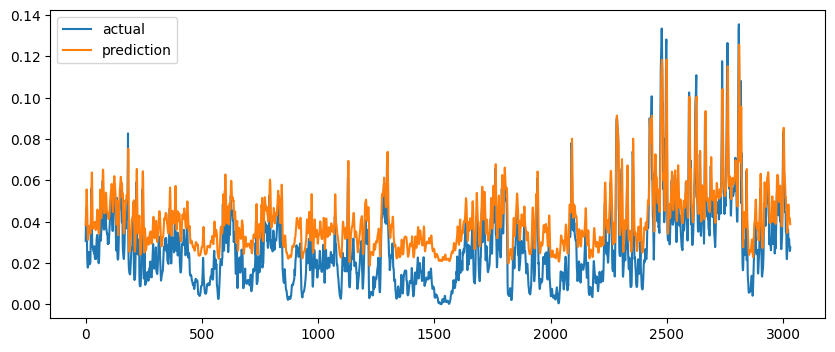

In [ ]:
# predict
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)

# plot predictions
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
# function to predict next 7 days
def predict_next_days(model, X_test, y_test, days):
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(-1)
    y_test = y_test.reshape(-1)
    for i in range(days):
        X_test = np.append(X_test, y_pred[-1])
        X_test = X_test[1:]
        X_test = X_test.reshape(1, X_test.shape[0], 1)
        y_pred = np.append(y_pred, model.predict(X_test))
        y_pred = y_pred.reshape(-1)
    return y_pred

In [ ]:
# predict next 7 days
y_pred = predict_next_days(model, X_test, y_test, 7)

# plot predictions
plt.figure(figsize=(10, 4))

plt.plot(y_test, label='actual')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()

95/95 [==============================] - 1s 5ms/step


2022-11-01 00:22:56.849209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-01 00:22:56.911411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
